## This is a program to self-consistently calculate the subsystem breaking condensate in multi-layer van der Waals heterostructures.

Copyright (C) 2024 Archisman Panigrahi <archi137@mit.edu>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.



**Author**: Archisman Panigrahi, Dept of Physics, Massachusetts Institute of Technology

**Research Article**:
*Non-Fermi liquids from subsystem symmetry breaking in van der Waals multilayers*, A. Panigrahi and A. Kumar (2024).


In [1]:
using LinearAlgebra
using Plots
gr()

Plots.GRBackend()

### Parameters

In [2]:
## Number of layers
N_z = 10;

## Relative permittivity
epsr=12.5;

## Effective mass
m_star_by_m_el = 0.07;

## Temperature
T_val = 0.5; ## actually, this is kB*T, in meV

## Density of electrons
density_set_per_cm_square = 50*10^10;

## Layer distance in z direction
az = 30; #angstrom

In [3]:
# Initial guess for delta (uniform in k_parallel)
delta_val = 1.5; ## meV

In [4]:
## Total Number of grid points in the 2D momentum space is NGridpts*NGridpts
NGridpts = 51;

## Momentum space cutoff
klim = 0.02; ## angstron inverse

kz_array = 2*pi*range(1/N_z,1,N_z);


In [5]:
kx_array = range(-klim,klim,NGridpts);
ky_array = range(-klim,klim,NGridpts);
cos_kz_array = cos.(kz_array)

10-element Vector{Float64}:
  0.8090169943749475
  0.30901699437494745
 -0.30901699437494734
 -0.8090169943749473
 -1.0
 -0.8090169943749475
 -0.30901699437494756
  0.30901699437494723
  0.8090169943749473
  1.0

In [6]:
delta_array = zeros(NGridpts, NGridpts);
newDelta_array = zeros(NGridpts, NGridpts); ##This is where new values will be calculated and copied to the previous array

band_energies = zeros(NGridpts, NGridpts, N_z);

band_population = zeros(NGridpts, NGridpts, N_z);

In [7]:
density_per_angstrom_square = density_set_per_cm_square/10^16;

In [8]:
system_area = (2*pi/(kx_array[2]-kx_array[1]))^2

6.168502750680816e7

In [9]:
n_initial = system_area * density_per_angstrom_square

3084.2513753404082

In [10]:
## This is an artificial parameter to make the zero momentum interaction zero. After all, while integrating, the interaction at zero momentum does not contribute as it still remains measure zero
dScreen = 10000.0; ## angstrom

The interaction is given by $ V(q) =\frac{e^2}{2\epsilon_0 \epsilon_r q} e^{-q a_z}$

To get a scale of interaction strength, we calculate $\frac{e^2}{2\epsilon_0 \epsilon_r q}$ at $q=1/\AA$. We will later include the exponential decay when we define the function `V_p_space`.

At $q = 1/\AA$, the interaction strength is, $V_{00} = \frac{e^2}{2 \epsilon_0 \epsilon_r} \times 1 \AA =  7238.05 \times (12.5/\epsilon_r) \times (meV\cdot \AA^2)$

In [11]:
V_00 = 7238.05*(12.5/epsr);  ## meV*angstrom^2, when there is no screening

In [12]:
V_amp = V_00/(system_area) ## meV

0.00011733884692198829

#### This function calculates the interaction amplitude between two momenta

In [13]:
function V_p_space(kx1::Float64, ky1::Float64, kx2::Float64, ky2::Float64, V_0::Float64, d_screen::Float64)
    return V_0*tanh(sqrt((kx1-kx2)^2 + (ky1-ky2)^2)*d_screen)^2 * exp(-(sqrt((kx1-kx2)^2 + (ky1-ky2)^2))*az)/(sqrt(10^(-10)+(kx1-kx2)^2 + (ky1-ky2)^2)) ## meV * angstrom^2/system area, so meV
end

V_p_space (generic function with 1 method)

In [14]:
V_p_space(0.,0.,0.,0.0001,V_amp, dScreen)

0.6751891449646514

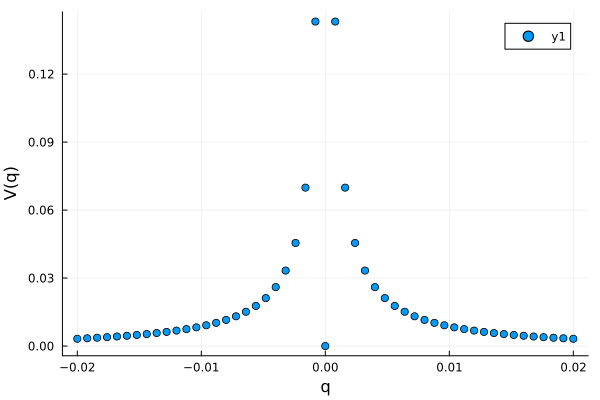

In [15]:
scatter(kx_array, V_p_space.(0.,0.,kx_array,0.,V_amp, dScreen),xlabel="q",ylabel="V(q)")

## Scale for kinetic energy

  h_bar² × (0.04 / angstrom)² / (2 × 0.07 × electron_mass) ➞ millielectronvolt

    = 87.0853 meV    [Energy or Torque]

#### This function calculates the kinetic energy (without interaction)

In [16]:
function band_kinetic_energy_without_delta(kx::Float64,ky::Float64)
    return (kx^2 + ky^2) * (87.0853/(0.04)^2) * 0.07/m_star_by_m_el    ## meV
end

band_kinetic_energy_without_delta (generic function with 1 method)

In [17]:
band_kinetic_energy_without_delta(klim,0.0)

21.771325

#### This function calculates the Fermi occupation at a particular energy, with given chemical potential and temperature

In [18]:
function fermi_occupation(En::Float64, Temp::Float64,chemPot::Float64)
    return 1/(exp((En-chemPot)/Temp)+1)
end

fermi_occupation (generic function with 1 method)

In [19]:
## Copies the value of the initial guess of Delta at every momentum.
## We will use this uniform distribution to begin the iterations
for ii = 1:NGridpts
    for jj = 1:NGridpts
        delta_array[ii,jj] = delta_val;
    end
end

In [20]:
## We assume that the iterations have converged when the difference between two etarations are less than the following

eps1 = 10^(-8); ## For finding chemical potential
eps2 = 10^(-5); ## For finding convergence of delta

#### Given a bandstructure, a fixed density, and temperature, this function calculates the chemical potential using bisection method

In [21]:
function find_new_chem_pot(bandstructure::Array{Float64, 3}, initial_guess_chem_pot::Float64, temp::Float64, n_electrons::Float64)
    delta_mu = maximum([maximum(bandstructure),maximum(delta_array)])
    new_chem_pot = copy(initial_guess_chem_pot)
    while_loop_index = 0;


    #println("error = ", sum(fermi_occupation.(bandstructure1, temp, new_chem_pot)) + sum(fermi_occupation.(bandstructure2, temp, new_chem_pot))- n_electrons)
    while(abs(sum(fermi_occupation.(bandstructure, temp, new_chem_pot)) - n_electrons) > eps1)
        if(sum(fermi_occupation.(bandstructure, temp, new_chem_pot)) > n_electrons)
            new_chem_pot -= delta_mu
            if(sum(fermi_occupation.(bandstructure, temp, new_chem_pot)) < n_electrons) ## If sign changes, we decrease the radius of binary search
                delta_mu = delta_mu/2
            end
        else
            new_chem_pot += delta_mu
            if(sum(fermi_occupation.(bandstructure, temp, new_chem_pot)) > n_electrons) ## If sign changes, we decrease the radius of binary search
                delta_mu = delta_mu/2
            end
        end
        while_loop_index+=1;
        #println("delta_mu = ", delta_mu)
        #println(while_loop_index, " new_chem_pot = ", new_chem_pot, " error = ", sum(fermi_occupation.(bandstructure1, temp, new_chem_pot)) + sum(fermi_occupation.(bandstructure2, temp, new_chem_pot))- n_electrons)
        if(while_loop_index>2000)
            println("ERROR, could not find chemical potential")
            break
        end
    end
    return new_chem_pot
end

find_new_chem_pot (generic function with 1 method)

#### Verify that the code to find chemical potential works

In [22]:
for ii = 1:NGridpts
    for jj = 1:NGridpts
        for kk = 1:N_z
            band_energies[ii,jj,kk] = band_kinetic_energy_without_delta(kx_array[ii],ky_array[jj]) + 2*cos(kz_array[kk])*delta_array[ii,jj];
    
        end
    end
end

In [23]:
@time chem_pot_now=find_new_chem_pot(band_energies,1.0,T_val,n_initial)

  0.379204 seconds (54.10 k allocations: 40.278 MiB, 6.65% gc time, 66.92% compilation time)


3.3864089411655165

In [24]:
mu=copy(chem_pot_now)

3.3864089411655165

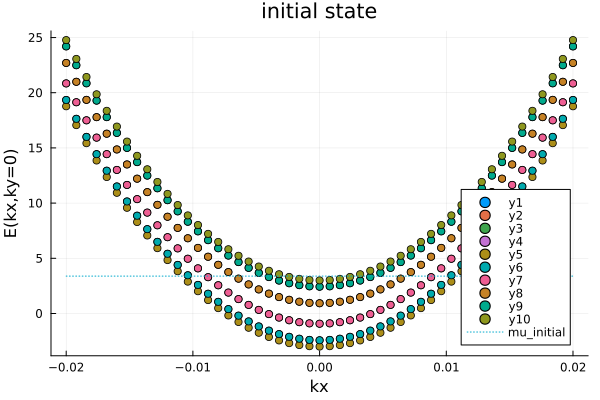

In [25]:
plt1 = scatter()
for ii = 1:N_z
    plt1 = scatter!(kx_array, band_energies[:,Int((NGridpts+1)/2),ii],xlabel="kx", ylabel="E(kx,ky=0)", title="initial state");
end
plt1 = plot!(kx_array,mu*ones(NGridpts),linestyle=:dot,label="mu_initial")
display(plt1)

In [26]:
for ii = 1:NGridpts
    for jj = 1:NGridpts
        for kk = 1:N_z
            band_population[ii,jj,kk] = fermi_occupation(band_energies[ii,jj,kk],T_val,mu)
        end
    end
end

In [27]:
### Here I am calculating populations of different bands, just to check how they are
sum(band_population[:,:,1])

92.6983678895962

In [28]:
sum(band_population[:,:,2])

222.13103163668436

In [29]:
sum(band_population[:,:,:])

3084.2513753405237

## Self-consistency calculation

In [30]:
iter_max = 200;
converge_iter = 0;
max_delta_list = zeros(iter_max);

for nruns = 1:iter_max
    chem_pot_now = find_new_chem_pot(band_energies, chem_pot_now,T_val,n_initial)
    for ii = 1:NGridpts
        for jj = 1:NGridpts
            for kk = 1:N_z
                band_energies[ii,jj,kk] = band_kinetic_energy_without_delta(kx_array[ii],ky_array[jj]) + 2*cos(kz_array[kk])*delta_array[ii,jj];
        
                band_population[ii,jj,kk] = fermi_occupation(band_energies[ii,jj,kk],T_val,chem_pot_now)
            end
        end
    end
    ### Using this new, bandstructure, we find a new chemical potential once again to stabilize the convergence.
    ### In some cases, this reduces the number of iterations from 150 to 5 !!!!! :)
    chem_pot_now = find_new_chem_pot(band_energies, chem_pot_now,T_val,n_initial)

    println(chem_pot_now)
    for ii = 1:NGridpts
        for jj = 1:NGridpts
            for kk = 1:N_z
                band_energies[ii,jj,kk] = band_kinetic_energy_without_delta(kx_array[ii],ky_array[jj]) + 2*cos(kz_array[kk])*delta_array[ii,jj];
        
                band_population[ii,jj,kk] = fermi_occupation(band_energies[ii,jj,kk],T_val,chem_pot_now)
            end
        end
    end

    newDelta_array = zeros(NGridpts, NGridpts);

    #@time Threads.@threads for ii = 1:NGridpts
    @time for ii = 1:NGridpts
        for jj = 1:NGridpts
            for kk = 1:NGridpts
                for ll = 1:NGridpts
                    #for zz = 1:N_z
                        newDelta_array[ii,jj] += -(1/N_z)*V_p_space(kx_array[ii], ky_array[jj], kx_array[kk], ky_array[ll], V_amp, dScreen) * sum(band_population[kk,ll,:].*cos_kz_array)
                    #end
                end
            end
        end
    end


    println("iter = ", nruns, " ,chemical_potential = ", chem_pot_now, " ,n_now = ", sum(band_population), ", max delta = ", maximum(newDelta_array)," ,change delta = ",maximum(abs.(delta_array - newDelta_array)))
    if maximum(abs.(delta_array - newDelta_array)) < eps2
            converge_iter = nruns
            println("converged after ", nruns, " iterations")
            break
    end
    delta_array = copy(newDelta_array);
    max_delta_list[nruns] = maximum(delta_array)

    if nruns == iter_max
        println("WARNING: DIDN'T CONVERGE after ", nruns, " iterations")
    end
    # plt3 = scatter(kx_array, band_energies[:,Int((NGridpts+1)/2),1],xlabel="kx", ylabel="E(kx,ky=0)", label = "E_plus", color=:red, title=string(nruns));
    # plt3 = scatter!(kx_array, band_energies[:,Int((NGridpts+1)/2),2],xlabel="kx", label = "E_minus", color=:blue);
    # plt3 = plot!(kx_array,chem_pot_now*ones(NGridpts),linestyle=:dot,label="mu_final")
    # display(plt3)

    # plt4 = scatter(kx_array, delta_array[:,Int((NGridpts+1)/2),1],xlabel="kx", label = "delta array");
    # display(plt4)
end

final_mu = copy(chem_pot_now)

3.3864089411655165
  9.037895 seconds (162.80 M allocations: 4.150 GiB, 5.78% gc time, 1.68% compilation time)
iter = 1 ,chemical_potential = 3.3864089411655165 ,n_now = 3084.2513753405237, max delta = 2.0765519660752947 ,change delta = 1.2519030659030121
3.6564994774899446
  8.875066 seconds (162.64 M allocations: 4.141 GiB, 5.77% gc time)
iter = 2 ,chemical_potential = 3.6564994774899446 ,n_now = 3084.251375341895, max delta = 2.351562927998682 ,change delta = 0.3580312741902896
3.6946979614514652
  8.825237 seconds (162.64 M allocations: 4.141 GiB, 5.86% gc time)
iter = 3 ,chemical_potential = 3.6946979614514652 ,n_now = 3084.251375346893, max delta = 2.566625057074948 ,change delta = 0.3030874510939374
3.686292447304106
  8.997118 seconds (162.64 M allocations: 4.141 GiB, 5.60% gc time)
iter = 4 ,chemical_potential = 3.686292447304106 ,n_now = 3084.251375350226, max delta = 2.7191397861736886 ,change delta = 0.18143519882238435
3.6664606513107367
  8.733572 seconds (162.64 M alloca

3.640260687380132

In [31]:
## Check that the final value of population is consistent with the initial state
println("n_final = ", sum(band_population),", total initial pop = ", n_initial)

n_final = 3084.2513753408884, total initial pop = 3084.2513753404082


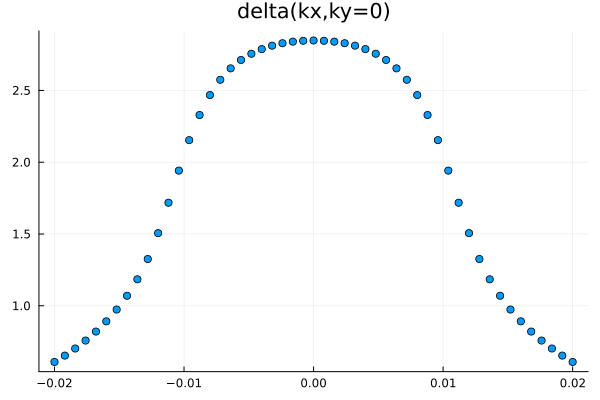

In [32]:
## Here I plot the momentum distribution of Delta(kx, ky=0) against kx
plt0 = scatter(kx_array, newDelta_array[:,Int((NGridpts+1)/2)],title="delta(kx,ky=0)",legend=false);
display(plt0)

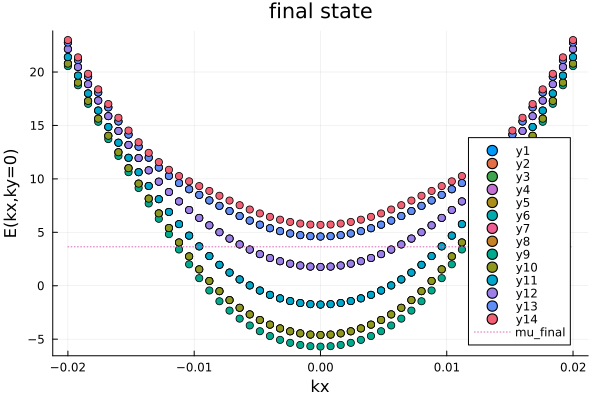

In [33]:
## Here I plot the band energies of the final (self-consistent mean-field) state
plt12 = scatter(kx_array, band_energies[:,Int((NGridpts+1)/2),1],xlabel="kx", ylabel="E(kx,ky=0)", title="final state");
plt12 = scatter!(kx_array, band_energies[:,Int((NGridpts+1)/2),2],xlabel="kx", ylabel="E(kx,ky=0)", title="final state");

plt12 = scatter!(kx_array, band_energies[:,Int((NGridpts+1)/2),3],xlabel="kx", ylabel="E(kx,ky=0)", title="final state");

plt12 = scatter!(kx_array, band_energies[:,Int((NGridpts+1)/2),4],xlabel="kx", ylabel="E(kx,ky=0)", title="final state");

for ii = 1:N_z
    plt12 = scatter!(kx_array, band_energies[:,Int((NGridpts+1)/2),ii],xlabel="kx", ylabel="E(kx,ky=0)", title="final state");
end
plt12 = plot!(kx_array,final_mu*ones(NGridpts),linestyle=:dot,label="mu_final")
display(plt12)

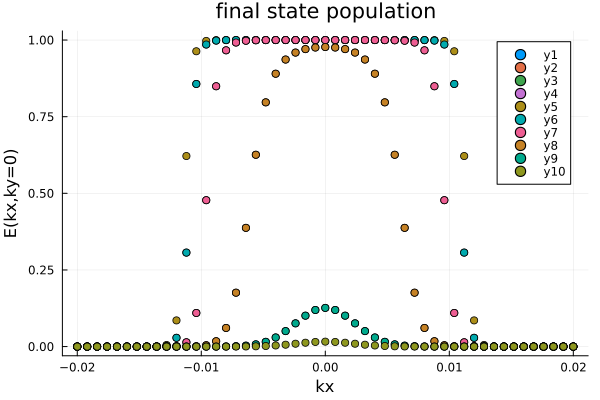

In [34]:
### Here I plot the band populations as a function of momentum for different bands
plt2 = scatter()
for ii = 1:N_z
    plt2 = scatter!(kx_array, band_population[:,Int((NGridpts+1)/2),ii],xlabel="kx", ylabel="E(kx,ky=0)", title="final state population");
end
display(plt2)

In [35]:
## Here I print the total populations of different bands
for ii = 1:N_z
    println(sum(band_population[:,:,ii]))
end

6.906749148782951
180.8790757107483
448.4318291557645
589.458313787758
632.038308029932
589.4583137877581
448.4318291557646
180.87907571074845
6.906749148782958
0.8611317048489286


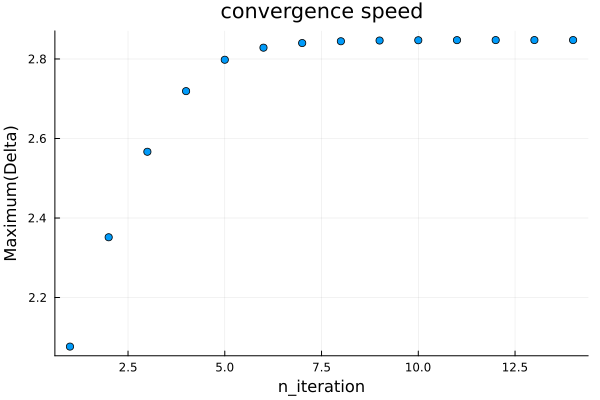

In [36]:
## This shows how quickly it converges
scatter(1:(converge_iter-1), max_delta_list[1:converge_iter-1],legend =false, title="convergence speed", xlabel="n_iteration", ylabel="Maximum(Delta)")

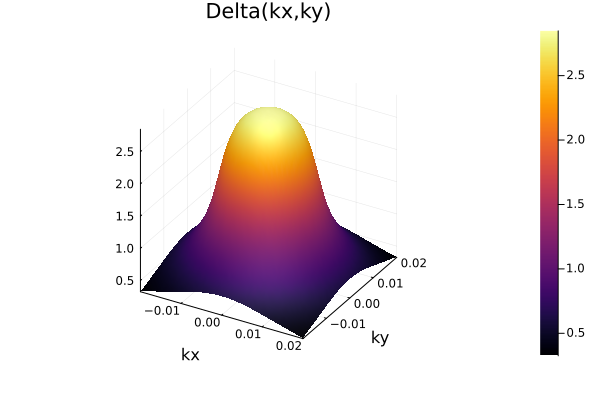

In [37]:
### 3D plot for momentum dependence of Delta
plot(kx_array,ky_array,delta_array,st=:surface,xlabel="kx",ylabel="ky",title="Delta(kx,ky)")

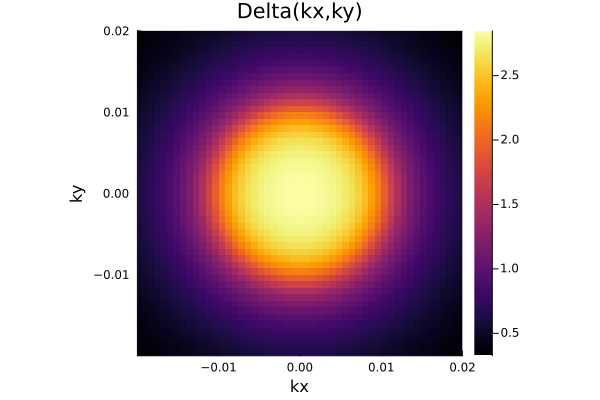

In [38]:
heatmap(kx_array,ky_array,delta_array,aspect_ratio=1,xlabel="kx",ylabel="ky",title="Delta(kx,ky)")
xlims!(minimum(kx_array), maximum(kx_array))
ylims!(minimum(ky_array), maximum(ky_array))

#### Maximum value of Delta(kx,ky): Usually at the kx=0=ky, but not always

In [39]:
maximum(delta_array) ## In meV

2.8475948429965214

Next we use the fact that

$\hbar² / (1 meV × (1 \AA)² × m_{el})$

    = 7619.96


In [40]:
mz_by_m_electron = 7619.96/(2*az^2 * maximum(delta_array))

1.4866269060441204

In [41]:
mz_by_m_parallel = mz_by_m_electron/0.07

21.237527229201717